In [10]:
! pip install datasets prettyprint evaluate rouge_score transformers torch pandas numpy peft trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 3.7 MB/s eta 0:00:00


# Full Fine-tuning Text2SQL

In [2]:
# Import necessary libraries
import torch  # PyTorch library for deep learning computations.
# Import tokenizer and model from transformers for Natural Language Processing tasks.
from datasets import Dataset, DatasetDict, load_dataset, interleave_datasets # Used for loading and managing datasets.
from transformers import GenerationConfig, TrainingArguments, Trainer, AutoModelForSeq2SeqLM, AutoTokenizer  # Components for model training and generation.
import time # Used for timing operations.
import evaluate # Used for model evaluation metrics.
import pandas as pd # Used for data manipulation and analysis.
import numpy as np # Used for numerical computations.

import warnings # Used for managing warning messages.
warnings.filterwarnings("ignore") # Ignore warning messages during execution.

# Check if a CUDA-enabled GPU is available, otherwise use CPU for computations.
device: str = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# Load the pre-trained tokenizer for the "t5-small" model
tokenizer = AutoTokenizer.from_pretrained("t5-small")

# Load the pre-trained "t5-small" model and move it to the selected device
pre_train_model = AutoModelForSeq2SeqLM.from_pretrained("t5-small").to(device)

# Iterate through a list of English prompts
for prompt in ["Hello, How are you?", "My name is Midhun"]:
    # Print the current input prompt
    print("Input:", prompt)

    # Tokenize the input prompt and add translation instructions
    # Return PyTorch tensors and move them to the selected device
    inputTokens = tokenizer("translate English to French: {}".format(prompt), return_tensors="pt").to(device)

    # Generate the French translation using the model
    # Limit the output to a maximum of 50 tokens
    outputs = pre_train_model.generate(inputTokens['input_ids'], attention_mask=inputTokens['attention_mask'], max_new_tokens=50)

    # Decode the generated output tokens into readable text and print the translation
    # Skip special tokens (like start and end tokens) in the output
    print("Output:", tokenizer.decode(outputs[0], skip_special_tokens=True))

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Input: Hello, How are you?
Output: Bonjour, Comment êtes-vous?
Input: My name is Midhun
Output: Mon nom est Midhun


In [9]:
print(pre_train_model)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

### Dataset Prepration

In [4]:
# Load dataset
dataset_scc_train = load_dataset("b-mc2/sql-create-context", split='train[:80%]')
dataset_scc_test  = load_dataset("b-mc2/sql-create-context", split='train[-20%:-10%]')
dataset_scc_val   = load_dataset("b-mc2/sql-create-context", split='train[-10%:]')

dataset = DatasetDict({ 'train': interleave_datasets([dataset_scc_train]),
                            'test': interleave_datasets([dataset_scc_test]),
                            'validation': interleave_datasets([dataset_scc_val])})

README.md:   0%|          | 0.00/4.43k [00:00<?, ?B/s]

sql_create_context_v4.json:   0%|          | 0.00/21.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/78577 [00:00<?, ? examples/s]

In [5]:
from pprint import pprint
print("-----Train Dataset----")
pprint(dataset['train'][0])
print("-----Test Dataset-----")
pprint(dataset['test'][0])
print("----Test Dataset:-----")
pprint(dataset['validation'][0])

-----Train Dataset----
{'answer': 'SELECT COUNT(*) FROM head WHERE age > 56',
 'context': 'CREATE TABLE head (age INTEGER)',
 'question': 'How many heads of the departments are older than 56 ?'}
-----Test Dataset-----
{'answer': 'SELECT date FROM table_name_11 WHERE away_team = "essendon"',
 'context': 'CREATE TABLE table_name_11 (date VARCHAR, away_team VARCHAR)',
 'question': 'On what Date did the Away team essendon play?'}
----Test Dataset:-----
{'answer': 'SELECT home_team FROM table_name_80 WHERE away_team = "lincoln '
           'city"',
 'context': 'CREATE TABLE table_name_80 (home_team VARCHAR, away_team VARCHAR)',
 'question': 'What is the Home team at the Lincoln City Away game?'}


In [6]:
def tokenize_function(example):
    """
    Tokenizes the input example and prepares it for the model.

    This function takes an example from the dataset, combines the context and
    question into a prompt, tokenizes the prompt and answer using the
    pre-trained tokenizer, and returns the example with added 'input_ids'
    and 'labels'.

    Args:
        example (dict): A dictionary containing 'context', 'question', and 'answer'.

    Returns:
        dict: The modified example with added 'input_ids' and 'labels'.
    """

    # Define special tokens to mark different sections of the input
    _context = "Tables:\n"
    _question = "\n\nQuestion:\n"
    _answer = "\n\nAnswer:\n"

    # Combine context and question into a prompt
    data_zip = zip(example['context'], example['question'])
    # Create the prompt string with special tokens
    prompt = [_context + context + _question + question + _answer for context, question in data_zip]

    # Tokenize the prompt and store as 'input_ids'
    example['input_ids'] = tokenizer(prompt, padding="max_length", truncation=True, return_tensors="pt").input_ids
    # Tokenize the answer and store as 'labels'
    example['labels'] = tokenizer(example['answer'], padding="max_length", truncation=True, return_tensors="pt").input_ids

    return example

# Apply the tokenize_function to the dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)
# Remove original text columns, as they are now represented by 'input_ids' and 'labels'
tokenized_datasets = tokenized_datasets.remove_columns(['question', 'context', 'answer'])
print("Tokenized Dataset")

Map:   0%|          | 0/62862 [00:00<?, ? examples/s]

Map:   0%|          | 0/7857 [00:00<?, ? examples/s]

Map:   0%|          | 0/7858 [00:00<?, ? examples/s]

Tokenized Dataset


In [7]:
pprint(tokenized_datasets.keys())
pprint(tokenized_datasets['train'][0].keys())
pprint(tokenized_datasets['train'][0]['input_ids'][:10])
pprint(tokenized_datasets['train'][0]['labels'][:10])
pprint(tokenized_datasets)

dict_keys(['train', 'test', 'validation'])
dict_keys(['input_ids', 'labels'])
[4398, 7, 10, 205, 4386, 6048, 332, 17098, 819, 41]
[3, 23143, 14196, 2847, 17161, 599, 1935, 61, 21680, 819]
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 62862
    })
    test: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 7857
    })
    validation: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 7858
    })
})


### Pre Fine-tuning test:

In [ ]:
index = 555  # Set the index to 555 to select the first example from the dataset

# Get the question, context, and answer from the 'test' split of the dataset
question = dataset['test'][index]['question']
context = dataset['test'][index]['context']
answer = dataset['test'][index]['answer']

# Create the prompt by formatting the context and question
prompt = f"""Tables:
{context}

Question:
{question}

Answer:
"""

# Tokenize the prompt and convert it to PyTorch tensors
inputs = tokenizer(prompt, return_tensors='pt')
# Move the input tensors to the 'cuda' device (GPU) if available
inputs = inputs.to('cuda')

# Generate the answer using the pre-trained model
output = tokenizer.decode(
    pre_train_model.generate(
        inputs["input_ids"],  # Pass the tokenized input to the model
        max_new_tokens=25,  # Limit the output to a maximum of 200 tokens
    )[0],  # Get the first element of the generated output
    skip_special_tokens=True  # Remove special tokens from the output
)

# Create a dashed line for visual separation in the output
dash_line = '-'.join('' for x in range(100))
# Print the prompt, actual answer, and the model's generated answer
print(dash_line)
print(f'Prompt:\n{prompt}')
print(dash_line)
print(f'Actual answer:\n{answer}\n')
print(dash_line)
pprint(f'pre_train_model Answer - Zero Zhot:\n\n{output}')

---------------------------------------------------------------------------------------------------
Prompt:
Tables:
CREATE TABLE table_name_33 (d_41 VARCHAR, r_51 VARCHAR)

Question:
Tell me the D 41 and R 51 of r 11

Answer:

---------------------------------------------------------------------------------------------------
Actual answer:
SELECT d_41 FROM table_name_33 WHERE r_51 = "r 11"

---------------------------------------------------------------------------------------------------
'pre_train_model Answer - Zero Zhot:\n\nTrue'


### Training

In [ ]:
fine_tuned_model = AutoModelForSeq2SeqLM.from_pretrained("t5-small", torch_dtype=torch.bfloat16)
fine_tuned_model = fine_tuned_model.to('cuda')
tokenizer = AutoTokenizer.from_pretrained("t5-small")

In [ ]:
# Set the directory to save the fine-tuned model and its checkpoints
output_dir = f'./full_fine_tuning_text2sql-{str(int(time.time()))}'

# Define training arguments using the TrainingArguments class
training_args = TrainingArguments(
    output_dir=output_dir,  # Directory to save model checkpoints
    learning_rate=5e-3,  # Learning rate for optimization
    num_train_epochs=2,  # Number of training epochs
    per_device_train_batch_size=16,  # Batch size per device during training
    per_device_eval_batch_size=16,  # Batch size per device during evaluation
    weight_decay=0.01,  # Weight decay for regularization
    logging_steps=50,  # Log training progress every 50 steps
    eval_strategy='steps',  # Evaluation strategy: evaluate every 'eval_steps'
    eval_steps=500,  # Evaluate every 500 steps
    report_to='none'  # Disable reporting to Weights & Biases (wandb.ai)
)

# Create a Trainer instance to manage the fine-tuning process
trainer = Trainer(
    model=fine_tuned_model,  # The model to fine-tune
    args=training_args,  # Training arguments
    train_dataset=tokenized_datasets['train'],  # Training dataset
    eval_dataset=tokenized_datasets['validation'],  # Evaluation dataset
)

# Start the fine-tuning process
trainer.train()

# Save the fine-tuned model to a directory
fine_tuned_model.save_pretrained("finetuned_model_text2sql")

Step,Training Loss,Validation Loss
500,0.106500,0.102565
1000,0.106000,0.087704
1500,0.092200,0.078421
2000,0.096000,0.072637
2500,0.083500,0.067698
3000,0.073300,0.062645
3500,0.073800,0.060724
4000,0.067700,0.056907
4500,0.059800,0.053573
5000,0.060400,0.051610


### Post Fine-tuning test:

In [ ]:
fine_tuned_model = AutoModelForSeq2SeqLM.from_pretrained("finetuned_model_text2sql")
fine_tuned_model = fine_tuned_model.to('cuda')

In [ ]:
index = 555  # Set the index to 0 to select the first example from the dataset

# Get the question, context, and answer from the 'test' split of the dataset
question = dataset['test'][index]['question']
context = dataset['test'][index]['context']
answer = dataset['test'][index]['answer']

# Create the prompt by formatting the context and question
prompt = f"""Tables:
{context}

Question:
{question}

Answer:
"""

# Tokenize the prompt and convert it to PyTorch tensors
inputs = tokenizer(prompt, return_tensors='pt')
# Move the input tensors to the 'cuda' device (GPU) if available
inputs = inputs.to('cuda')

# Generate the answer using the pre-trained model
output = tokenizer.decode(
    fine_tuned_model.generate(
        inputs["input_ids"],  # Pass the tokenized input to the model
        max_new_tokens=25,  # Limit the output to a maximum of 25 tokens
    )[0],  # Get the first element of the generated output
    skip_special_tokens=True  # Remove special tokens from the output
)

# Create a dashed line for visual separation in the output
dash_line = '-'.join('' for x in range(100))
# Print the prompt, actual answer, and the model's generated answer
print(dash_line)
print(f'Prompt:\n{prompt}')
print(dash_line)
print(f'Actual answer:\n{answer}\n')
print(dash_line)
pprint(f'fine_tuned_model Answer - Zero Zhot:\n\n{output}')

---------------------------------------------------------------------------------------------------
Prompt:
Tables:
CREATE TABLE table_name_33 (d_41 VARCHAR, r_51 VARCHAR)

Question:
Tell me the D 41 and R 51 of r 11

Answer:

---------------------------------------------------------------------------------------------------
Actual answer:
SELECT d_41 FROM table_name_33 WHERE r_51 = "r 11"

---------------------------------------------------------------------------------------------------
('fine_tuned_model Answer - Zero Zhot:\n'
 '\n'
 'SELECT d_41 FROM table_name_33 WHERE r_51 = "11" AND')


In [ ]:

# Iterate through a list of English prompts
for prompt in ["Hello, How are you?", "My name is Midhun"]:
    # Print the current input prompt
    print("Input:", prompt)

    # Tokenize the input prompt and add translation instructions
    # Return PyTorch tensors and move them to the selected device
    inputTokens = tokenizer("translate English to French: {}".format(prompt), return_tensors="pt").to(device)

    # Generate the French translation using the model
    # Limit the output to a maximum of 50 tokens
    outputs = fine_tuned_model.generate(inputTokens['input_ids'], attention_mask=inputTokens['attention_mask'], max_new_tokens=50)

    # Decode the generated output tokens into readable text and print the translation
    # Skip special tokens (like start and end tokens) in the output
    print("Output:", tokenizer.decode(outputs[0], skip_special_tokens=True))

Input: Hello, How are you?
Output: SELECT t1.name FROM AIRLINES AS t1 JOIN AIRLINES AS t2 ON t1.id = t2.id GROUP BY t2.id OR
Input: My name is Midhun
Output: SELECT t1.name FROM t1.address_address AS t1 JOIN t2.address AS t3 ON t1.address_id = t2.a


## Evaluate the Model Quantitatively (with ROUGE Metric)

In [ ]:
# Perform inferences for test dataset. Do 25 only, due to time it takes.

questions = dataset['test'][0:25]['question']
contexts = dataset['test'][0:25]['context']
human_baseline_answers = dataset['test'][0:25]['answer']

original_model_answers = []
finetuned_model_answers = []

for idx, question in enumerate(questions):

    prompt = f"""Tables:
{contexts[idx]}

Question:
{question}

Answer:
"""

    input_ids = tokenizer(prompt, return_tensors="pt").input_ids
    input_ids = input_ids.to('cuda')

    human_baseline_text_output = human_baseline_answers[idx]

    original_model_outputs = pre_train_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=300))
    original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)
    original_model_answers.append(original_model_text_output)

    finetuned_model_outputs = fine_tuned_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=300))
    finetuned_model_text_output = tokenizer.decode(finetuned_model_outputs[0], skip_special_tokens=True)
    finetuned_model_answers.append(finetuned_model_text_output)

zipped_summaries = list(zip(human_baseline_answers, original_model_answers, finetuned_model_answers))

df = pd.DataFrame(zipped_summaries, columns = ['human_baseline_answers', 'original_model_answers', 'finetuned_model_answers'])


In [ ]:
rouge = evaluate.load('rouge')

original_model_results = rouge.compute(
    predictions=original_model_answers,
    references=human_baseline_answers[0:len(original_model_answers)],
    use_aggregator=True,
    use_stemmer=True,
)
print('ORIGINAL MODEL:')
print(original_model_results)


finetuned_model_results = rouge.compute(
    predictions=finetuned_model_answers,
    references=human_baseline_answers[0:len(finetuned_model_answers)],
    use_aggregator=True,
    use_stemmer=True,
)
print('FINE-TUNED MODEL:')
print(finetuned_model_results)


ORIGINAL MODEL:
{'rouge1': np.float64(0.038709677419354833), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.02838709677419355), 'rougeLsum': np.float64(0.02838709677419355)}
FINE-TUNED MODEL:
{'rouge1': np.float64(0.44897503465146693), 'rouge2': np.float64(0.38769657479014596), 'rougeL': np.float64(0.44434140997678573), 'rougeLsum': np.float64(0.44636913668773753)}


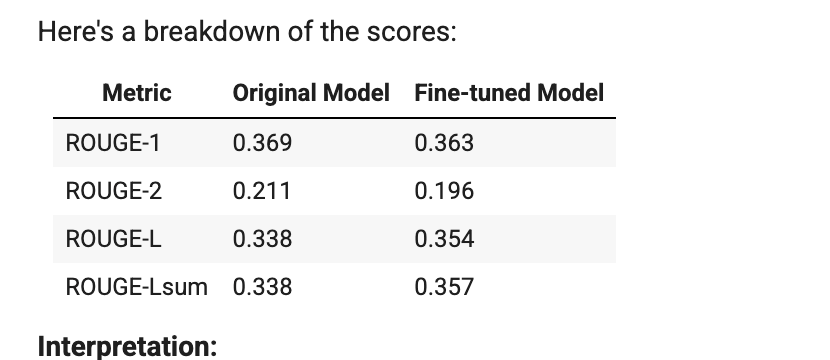


ROUGE-L and ROUGE-Lsum: These metrics consider the longest common subsequence (LCS) between the generated and reference texts, which gives a better indication of overall sentence similarity. Here, the fine-tuned model has noticeably higher ROUGE-L and ROUGE-Lsum scores compared to the original model. This suggests that the fine-tuned model might have generated text that is more semantically similar to the reference text, even if it doesn't have as much word-for-word overlap.



In [ ]:
!cp -r /content/finetuned_model_text2sql /content/drive/MyDrive/LLM_fine_tuning

In [26]:
# LORA
from peft import  LoraConfig, TaskType


lora_model= AutoModelForSeq2SeqLM.from_pretrained("t5-small", torch_dtype=torch.bfloat16)
lora_model = lora_model.to('cuda')
tokenizer = AutoTokenizer.from_pretrained("t5-small")

# Define the configuration for LoRA (Low-Rank Adaptation) using LoraConfig
peft_config = LoraConfig(
        inference_mode=False,  # Set to False for inference_mode
        lora_alpha=16,  # Scaling factor for the LoRA updates. Controls the impact of LoRA layers.
        lora_dropout=0.5,  # Dropout probability for the LoRA layers, helps prevent overfitting.
        r=16,  # Rank of the LoRA update matrices. Lower rank leads to fewer trainable parameters.
        bias="none",  # Whether to add a bias term to the LoRA layers. "none" means no bias is added.
        task_type=TaskType.SEQ_2_SEQ_LM,# Specifies the task type as sequence-to-sequence language modeling.
        target_modules=["q", "v", "o"],  # Specifies the modules to which LoRA will be applied. Here, it's applied to 'q' and 'v' modules.
        modules_to_save=["lm_head"],
        )

lora_model.add_adapter(peft_config, adapter_name="adapter_text2sql")
lora_model.set_adapter("adapter_text2sql")
pprint(lora_model)


T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): lora.Linear(
                (base_layer): Linear(in_features=512, out_features=512, bias=False)
                (lora_dropout): ModuleDict(
                  (adapter_text2sql): Dropout(p=0.5, inplace=False)
                )
                (lora_A): ModuleDict(
                  (adapter_text2sql): Linear(in_features=512, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (adapter_text2sql): Linear(in_features=16, out_features=512, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
       

In [18]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = model.num_parameters()
    for _, param in model.named_parameters():
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )
print_trainable_parameters(lora_model)


trainable params: 17334272 || all params: 77840896 || trainable%: 22.26884952608973


In [32]:
# Set the directory to save the fine-tuned model and its checkpoints
output_dir = f'./lora_tuning_text2sql-{str(int(time.time()))}'

# Define training arguments using the TrainingArguments class
training_args = TrainingArguments(
    output_dir=output_dir,  # Directory to save model checkpoints
    learning_rate=5e-5,  # Learning rate for optimization
    num_train_epochs=1,  # Number of training epochs
    per_device_train_batch_size=32,  # Batch size per device during training
    per_device_eval_batch_size=32,  # Batch size per device during evaluation
    weight_decay=0.01,  # Weight decay for regularization
    logging_steps=50,  # Log training progress every 50 steps
    eval_strategy='steps',  # Evaluation strategy: evaluate every 'eval_steps'
    eval_steps=1000,  # Evaluate every 500 steps
    report_to='none'  # Disable reporting to Weights & Biases (wandb.ai)
)

# Create a Trainer instance to manage the fine-tuning process
trainer = Trainer(
    model=lora_model,  # The model to fine-tune
    args=training_args,  # Training arguments
    train_dataset=tokenized_datasets['train'],  # Training dataset
    eval_dataset=tokenized_datasets['validation'],  # Evaluation dataset
)

# Start the fine-tuning process
trainer.train()

# Save the fine-tuned model to a directory
lora_model.save_pretrained("lora_model_text2sql")

Step,Training Loss,Validation Loss
1000,0.231400,0.196850


In [24]:

# Iterate through a list of English prompts
for prompt in ["Hello, How are you?", "My name is Midhun"]:
    # Print the current input prompt
    print("Input:", prompt)

    # Tokenize the input prompt and add translation instructions
    # Return PyTorch tensors and move them to the selected device
    inputTokens = tokenizer("translate English to French: {}".format(prompt), return_tensors="pt").to(device)

    # Generate the French translation using the model
    # Limit the output to a maximum of 50 tokens
    outputs = lora_model.generate(inputTokens['input_ids'], attention_mask=inputTokens['attention_mask'], max_new_tokens=50)

    # Decode the generated output tokens into readable text and print the translation
    # Skip special tokens (like start and end tokens) in the output
    print("Output:", tokenizer.decode(outputs[0], skip_special_tokens=True))

Input: Hello, How are you?
Output: Bonjour, comment êtes-vous?
Input: My name is Midhun
Output: Mon nom est Midhun


In [183]:
index = 555  # Set the index to 0 to select the first example from the dataset

# Get the question, context, and answer from the 'test' split of the dataset
question = dataset['test'][index]['question']
context = dataset['test'][index]['context']
answer = dataset['test'][index]['answer']

# Create the prompt by formatting the context and question
prompt = f"""Tables:
{context}

Question:
{question}

Answer:
"""

# Tokenize the prompt and convert it to PyTorch tensors
inputs = tokenizer(prompt, return_tensors='pt')
# Move the input tensors to the 'cuda' device (GPU) if available
inputs = inputs.to('cuda')

# Generate the answer using the pre-trained model
output = tokenizer.decode(
    lora_model.generate(
        inputs["input_ids"],  # Pass the tokenized input to the model
        max_new_tokens=25,  # Limit the output to a maximum of 25 tokens
    )[0],  # Get the first element of the generated output
    skip_special_tokens=True  # Remove special tokens from the output
)

# Create a dashed line for visual separation in the output
dash_line = '-'.join('' for x in range(100))
# Print the prompt, actual answer, and the model's generated answer
print(dash_line)
print(f'Prompt:\n{prompt}')
print(dash_line)
print(f'Actual answer:\n{answer}\n')
print(dash_line)
pprint(f'fine_tuned_model Answer - Zero Zhot:\n\n{output}')

---------------------------------------------------------------------------------------------------
Prompt:
Tables:
CREATE TABLE table_name_33 (d_41 VARCHAR, r_51 VARCHAR)

Question:
Tell me the D 41 and R 51 of r 11

Answer:

---------------------------------------------------------------------------------------------------
Actual answer:
SELECT d_41 FROM table_name_33 WHERE r_51 = "r 11"

---------------------------------------------------------------------------------------------------
('fine_tuned_model Answer - Zero Zhot:\n'
 '\n'
 'Question: Tell me the D 41 and R 51 of r 11 answer: CREATE TABLE table_name_')


In [130]:
# Perform inferences for test dataset. Do 25 only, due to time it takes.

questions = dataset['test'][0:25]['question']
contexts = dataset['test'][0:25]['context']
human_baseline_answers = dataset['test'][0:25]['answer']

original_model_answers = []
finetuned_model_answers = []

for idx, question in enumerate(questions):

    prompt = f"""Tables:
{contexts[idx]}

Question:
{question}

Answer:
"""

    input_ids = tokenizer(prompt, return_tensors="pt").input_ids
    input_ids = input_ids.to('cuda')

    human_baseline_text_output = human_baseline_answers[idx]

    original_model_outputs = pre_train_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=300))
    original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)
    original_model_answers.append(original_model_text_output)

    finetuned_model_outputs = lora_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=300))
    finetuned_model_text_output = tokenizer.decode(finetuned_model_outputs[0], skip_special_tokens=True)
    finetuned_model_answers.append(finetuned_model_text_output)

zipped_summaries = list(zip(human_baseline_answers, original_model_answers, finetuned_model_answers))

df = pd.DataFrame(zipped_summaries, columns = ['human_baseline_answers', 'original_model_answers', 'finetuned_model_answers'])


In [131]:
rouge = evaluate.load('rouge')

original_model_results = rouge.compute(
    predictions=original_model_answers,
    references=human_baseline_answers[0:len(original_model_answers)],
    use_aggregator=True,
    use_stemmer=True,
)
print('ORIGINAL MODEL:')
print(original_model_results)


finetuned_model_results = rouge.compute(
    predictions=finetuned_model_answers,
    references=human_baseline_answers[0:len(finetuned_model_answers)],
    use_aggregator=True,
    use_stemmer=True,
)
print('FINE-TUNED MODEL:')
print(finetuned_model_results)


ORIGINAL MODEL:
{'rouge1': np.float64(0.038709677419354833), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.02838709677419355), 'rougeLsum': np.float64(0.02838709677419355)}
FINE-TUNED MODEL:
{'rouge1': np.float64(0.3078347059033051), 'rouge2': np.float64(0.11343457742768087), 'rougeL': np.float64(0.2620827332641973), 'rougeLsum': np.float64(0.26065151029464206)}
